In [3]:
 # Initial imports
import nltk
import json
import re
import spacy
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
import pandas as pd
import requests
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.util import ngrams
from itertools import chain
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
from pathlib import Path
from newsapi import NewsApiClient

from nltk.sentiment.vader import SentimentIntensityAnalyzer

get_ipython().run_line_magic("matplotlib", "inline")

# Init API from News API 
newsapi = NewsApiClient(api_key='f734c8f04d2642cb8952bb568aeff1fa')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johnh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

#retreive BTC News 

Bitcoin_recent_news = newsapi.get_everything(q='Bitcoin',
                                          sources= None,
                                          exclude_domains ='youtube.com',
                                          qintitle = 'Bitcoin',
                                          from_param='2020-05-11',
                                          to ='2020-06-09',
                                          language='en',
                                          sort_by='relevancy')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johnh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
#pulling content about BTC for sentimental analysis
def create_df(news):
    articles = []
    for article in news:
        try:
            title = article["title"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "text": text,
                "date": date,
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [7]:
# Create a DataFrame with the news in English
btc_news_df = create_df(Bitcoin_recent_news["articles"])

In [27]:
btc_news_df

,date,text,title
0,2020-05-16,J.K. Rowling has been drinking a lot and you'd...,J.K. Rowling is four cocktails in and talking ...
1,2020-06-09,The Winklevoss twinsthe brothers Mark Zuckerbe...,"God Help Us, the Winklevoss Twins Are Co-Produ..."
2,2020-05-13,Over the last few weeks all eyes in the crypto...,FalconX raises $17M to power its crypto tradin...
3,2020-06-04,If youre planning to do some protesting and yo...,How to Buy a Burner Phone
4,2020-05-11,Since the first Bitcoin block was generated ba...,It Happened: Bitcoin Just Experienced Third Ha...
5,2020-05-28,Reuters\r\n<ul><li>Goldman Sachs gave five rea...,Goldman Sachs lists 5 reasons why bitcoin is '...
6,2020-06-02,<ul><li>Famed investor Michael Novogratz tweet...,'Get on the train': Famed investor Michael Nov...
7,2020-05-25,Our robot colleague Satoshi Nakaboto writes ab...,Satoshi Nakaboto: ‘Bitcoin continues downtrend...
8,2020-05-14,The move is the latest in a string of positive...,JPMorgan Extends Banking Services To Bitcoin E...
9,2020-05-26,Our robot colleague Satoshi Nakaboto writes ab...,Satoshi Nakaboto: ‘Visa approves launch of cry...


In [23]:
#Sentiment calculation based on compound score
def get_sentiment(score):
  
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [24]:
# Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in btc_news_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
btc_sentiment_news_df = btc_news_df.join(title_sentiment_df).join(text_sentiment_df)

btc_sentiment_news_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.056560,0.035850,0.907300,0.056850,-0.15000,0.257780,0.067350,0.911750,0.020800,0.400000
std,0.273152,0.089466,0.115267,0.097842,0.67082,0.402824,0.055604,0.056233,0.044864,0.820783
min,-0.571900,0.000000,0.696000,0.000000,-1.00000,-0.585900,0.000000,0.812000,0.000000,-1.000000
25%,-0.202300,0.000000,0.809750,0.000000,-1.00000,0.000000,0.000000,0.902250,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.00000,0.507000,0.090000,0.910000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.114000,0.00000,0.507000,0.090000,0.915000,0.000000,1.000000
max,0.585900,0.304000,1.000000,0.291000,1.00000,0.801600,0.188000,1.000000,0.134000,1.000000


In [12]:
#function for procuring news from raw API output for BTC recent news 
def create_txt(news):
    articles = []
    for article in news:
        try:
            text = article["content"]
           

            articles.append({
                "text": text,
            
            })
        except AttributeError:
            pass

    return (articles)


In [25]:

# getting just str from raw API output fot BTC recent news  
btc_news_txt = create_txt(Bitcoin_recent_news["articles"])
btc_values = [d['text'] for d in btc_news_txt ]

raw_btc_news_text = ''.join(btc_values)

# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

#Define preprocess function for raw_btc_news_text, run function
def process_text(doc):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    sw_addons = {'every','daywelcome','charsour'}
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    return output

tokenized_btc_news_text = process_text(raw_btc_news_text)

print(tokenized_btc_news_text)


['jk', 'rowling', 'ha', 'drinking', 'lot', 'youd', 'better', 'believe', 'ha', 'thought', 'bitcoinnotedterf', 'author', 'cuckoos', 'calling', 'rowlingdecided', 'friday', 'wa', 'perfect', 'time', 'learn', 'charsthe', 'winklevoss', 'twinsthe', 'brother', 'mark', 'zuckerberg', 'allegedly', 'stole', 'idea', 'facebook', 'fromare', 'making', 'movie', 'deadline', 'reported', 'week', 'doesnt', 'seem', 'masturbatory', 'enough', 'r', 'charsover', 'last', 'week', 'eye', 'crypto', 'world', 'glued', 'halvening', 'nighreligious', 'moment', 'blockchain', 'realm', 'amount', 'new', 'bitcoin', 'mined', 'distri', 'charsif', 'youre', 'planning', 'protesting', 'dont', 'want', 'risk', 'expensive', 'smartphone', 'processor', 'simply', 'want', 'keep', 'anonymous', 'possible', 'youre', 'outconsider', 'buying', 'charssince', 'first', 'bitcoin', 'block', 'wa', 'generated', 'back', 'three', 'halving', 'event', 'taking', 'place', 'block', 'mined', 'approximately', 'four', 'year', 'bitcoin', 'halving', 'charsreuters

In [14]:
# get top 10 word counts
word_counts = Counter(tokenized_btc_news_text)
print(dict(word_counts.most_common(10)))

{'bitcoin': 38, 'satoshi': 20, 'nakaboto': 20, 'another': 11, 'robot': 10, 'colleague': 10, 'writes': 10, 'fucking': 10, 'edition': 10, 'today': 10}


In [15]:
#ngrams 
bigram_counts = Counter(ngrams(tokenized_btc_news_text, n=2))
print(dict(bigram_counts))


{('jk', 'rowling'): 1, ('rowling', 'drinking'): 1, ('drinking', 'lot'): 1, ('lot', 'youd'): 1, ('youd', 'better'): 1, ('better', 'believe'): 1, ('believe', 'thoughts'): 1, ('thoughts', 'bitcoinnotedterf'): 1, ('bitcoinnotedterf', 'author'): 1, ('author', 'cuckoos'): 1, ('cuckoos', 'calling'): 1, ('calling', 'rowlingdecided'): 1, ('rowlingdecided', 'friday'): 1, ('friday', 'perfect'): 1, ('perfect', 'time'): 1, ('time', 'learn'): 1, ('learn', 'charsthe'): 1, ('charsthe', 'winklevoss'): 1, ('winklevoss', 'twinsthe'): 1, ('twinsthe', 'brothers'): 1, ('brothers', 'mark'): 1, ('mark', 'zuckerberg'): 1, ('zuckerberg', 'allegedly'): 1, ('allegedly', 'stole'): 1, ('stole', 'idea'): 1, ('idea', 'facebook'): 1, ('facebook', 'fromare'): 1, ('fromare', 'making'): 1, ('making', 'movie'): 1, ('movie', 'deadline'): 1, ('deadline', 'reported'): 1, ('reported', 'week'): 1, ('week', 'doesnt'): 1, ('doesnt', 'seem'): 1, ('seem', 'masturbatory'): 1, ('masturbatory', 'enough'): 1, ('enough', 'r'): 1, ('r',

In [26]:
#func for processing text for btc_news worcloud

def process_text(doc):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    sw_addons = {'every','daywelcome','charsour'}
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    return ' '.join(output)

# Process text for wordcloud creation
big_str = ''.join(raw_btc_news_text)
input_text_wordcloud_btc = process_text(big_str)
input_text_wordcloud_btc

'jk rowling ha drinking lot youd better believe ha thought bitcoinnotedterf author cuckoos calling rowlingdecided friday wa perfect time learn charsthe winklevoss twinsthe brother mark zuckerberg allegedly stole idea facebook fromare making movie deadline reported week doesnt seem masturbatory enough r charsover last week eye crypto world glued halvening nighreligious moment blockchain realm amount new bitcoin mined distri charsif youre planning protesting dont want risk expensive smartphone processor simply want keep anonymous possible youre outconsider buying charssince first bitcoin block wa generated back three halving event taking place block mined approximately four year bitcoin halving charsreutersulligoldman sachs gave five reason think bitcoin asset class suitable investment presentation wednesday morningliligoldman observed crypt charsullifamed investor michael novogratz tweeted monday bitcoin soon take resistance level telling follower get trainlilinovogratz said turmoil rob

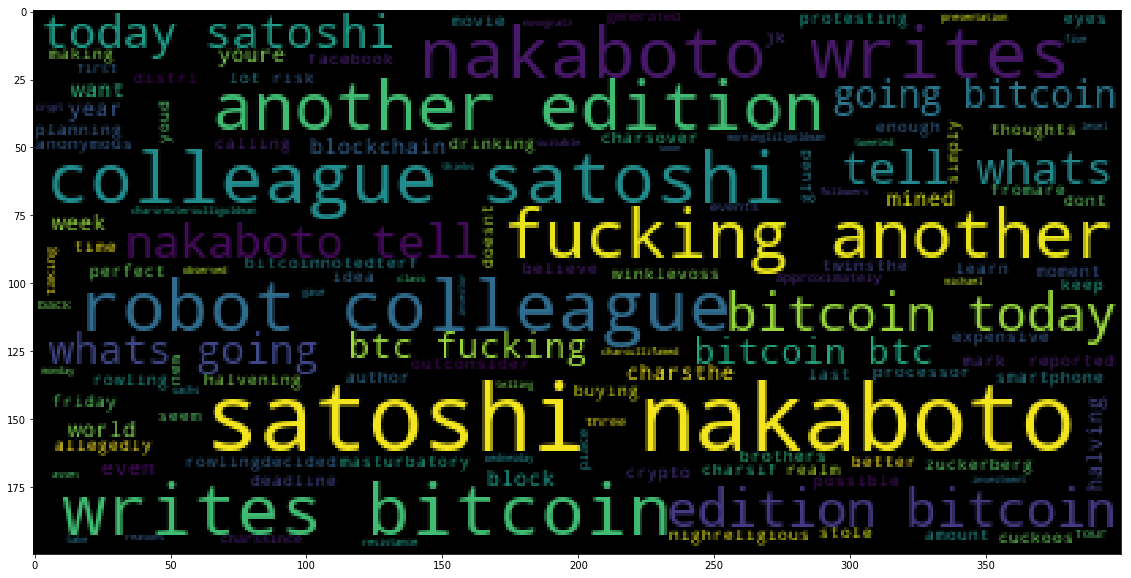

In [19]:
wc = WordCloud().generate(input_text_wordcloud_btc)
plt.figure(figsize= (20,10))
plt.imshow(wc)

In [20]:
#NER w/SPACY
nlp = spacy.load("en_core_web_sm")

In [21]:
doc = nlp(input_text_wordcloud_btc)
displacy.render(doc, style='ent')